# Get Statistics of Final Images

In [1]:
import csv
import glob
import math
import numpy as np
import mpmath as mp
import scipy.integrate as integrate
from scipy.stats import norm, exponnorm
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from astropy.io import fits
from scipy import stats
from astropy.table import QTable
from astropy.modeling import models, fitting

import matplotlib.pyplot as plt

In [2]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

## Load Image

In [3]:
cell = 0.3 # arcsec
imdir = "/rds/user/pmk46/hpc-work/19A-056/final/images/*.fits"
qso_catalog = QTable.read('Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')

def get_cutout(data, cutout_size, shift=(0, 0)):
    """ 
    Get a cutout of the centre of a 2D data array.
    """

    N = data.shape[0]
    pc = N // 2

    nstart = max(pc - cutout_size // 2, 0)
    nend = min(pc + cutout_size // 2, N)
    return data[nstart-shift[0]:nend-shift[0], nstart-shift[1]:nend-shift[1]]

peaks = []
offpoints = []
images = []
zlist = []
dllist = []


for imfits in glob.glob(imdir):
    name = imfits.split("/")[-1].split(".")[0][:-4]
    strl = list(name)
    strl[3] = "_"
    name = "".join(strl)

    print(name)
                                             
    image_data = fits.open(imfits)[0].data[0, 0]

    if not np.isnan(image_data).any():
        qso_cutout = get_cutout(image_data, 4) 
        blank_cutout = get_cutout(image_data, 4, shift=(144, 144))

        peak = np.mean(qso_cutout)
        blank = np.mean(blank_cutout)

        images.append(get_cutout(image_data, 64))

        z = qso_catalog[qso_catalog["QSO-Name"] == name]["Redshift"].value[0]
        dl = cosmo.luminosity_distance(z).to("m").value
        peak = peak * 4 * np.pi * dl**2 * 1e-26
        blank = blank * 4 * np.pi * dl**2 * 1e-26

        peaks.append([peak])
        offpoints.append([blank])

        zlist.append(z)
        dllist.append(dl)
        
    else:
        print(f"NaN in {imfits}!")

QSO_J2329-0301
QSO_J2228+0152
QSO_J1036-0232
QSO_J0818+1722
QSO_J0911+0152
QSO_J1137+0045
QSO_J0106-0030
QSO_J0231-2850
QSO_J0045+0901
QSO_J0038-1025
QSO_J1306+0356
QSO_J1048+4637
QSO_J1516+4228
QSO_J2211-3206
QSO_J2219+0102
QSO_J1110-1329
QSO_J0330-4025
QSO_J1641+3755
QSO_J1431-0724
QSO_J0857+0056
QSO_J2228+0128
QSO_J1630+4012
QSO_J1609+3041
QSO_J0226+0302
QSO_J1347-0157
QSO_J0202-0251
QSO_J1350-0027
QSO_J1602+4228
QSO_J1257+6349
QSO_J2348-3054
QSO_J1448+4333
QSO_J0402+2451
QSO_J1526-2050
QSO_J2356+0023
QSO_J2240-1839
QSO_J2232+0012
QSO_J0303-0019
QSO_J2310+1855
QSO_J1428-1602
QSO_J0844-0052
QSO_J0004-0049
QSO_J2132+1217
QSO_J0210-0456
QSO_J1137+3549
QSO_J1603+5510
QSO_J0227-0605
QSO_J0221-0802
QSO_J1148+0702
QSO_J1416+0015
QSO_J0853+0139
QSO_J1429-0104
QSO_J1429+5447
QSO_J2236+0032
QSO_J0859+0022
QSO_J1512+4422
QSO_J1558-0724
QSO_J1629+2407
QSO_J0009+3252
QSO_J0216-0455
QSO_J0842+1218
QSO_J2318-0246
QSO_J1342+0928
QSO_J0100+2802
QSO_J1030+0524
QSO_J0935-0110
QSO_J0024+3913
QSO_J2318-

In [4]:
images = np.array(images)
mad_list = np.array([1.4826 * np.nanmedian(np.abs(image)-np.nanmedian(np.abs(image))) for image in images]) * 4 * np.pi * np.array(dllist)**2 * 1e-26

In [ ]:
csv_list = np.array([np.squeeze(peaks), np.squeeze(offpoints), np.squeeze(zlist), np.squeeze(dllist),np.squeeze(mad_list),]).T

with open('imstats.csv', 'w') as csv:
    for row in csv_list:
        print(row)
        csv.write(",".join(row.astype(str)))
        csv.write("\n")

In [5]:

idx = np.where((np.array(zlist)<6.5) & (np.array(mad_list)<1e26) & (~np.isnan(mad_list)))
print(zlist)
medim = np.nanmedian(images[idx], axis=0)
avgim = np.nanmean(images[idx], axis=0)
trimmean = stats.trim_mean(images[idx], 0.1, axis=0)

[6.4164, 6.08, 6.3809, 6.02, 6.07, 6.4, 6.06, 6.0, 6.42, 6.0039, 6.0337, 6.2284, 6.13, 6.3394, 6.1492, 6.5157, 6.25, 6.047, 6.14, 6.35, 6.01, 6.065, 6.16, 6.5412, 6.15, 6.03, 6.49, 6.09, 6.02, 6.9018, 6.14, 6.18, 6.5864, 6.0, 6.01, 6.18, 6.078, 6.0031, 6.1498, 6.25, 6.1, 6.5881, 6.4323, 6.03, 6.04, 6.2, 6.161, 6.339, 6.03, 6.01, 6.8, 6.1831, 6.4, 6.3903, 6.19, 6.11, 6.476, 6.1, 6.01, 6.0763, 6.05, 7.5413, 6.3258, 6.308, 6.08, 6.61, 6.1458, 6.253, 6.07, 6.2, 6.072, 6.08, 6.03, 6.2341, 6.02, 6.27, 6.69, 6.1225, 6.69, 6.4189, 6.13, 6.1722, 6.4435, 6.02, 7.0842, 6.15, 6.2, 6.133, 6.06, 6.21, 6.0008, 6.26, 6.006, 6.0962, 6.1247, 6.16, 6.01, 6.92, 6.26, 6.78, 6.6759, 6.7909, 6.3643, 6.13, 6.04, 6.13, 6.18, 6.04, 6.3379, 6.09, 6.27, 7.01, 6.658, 6.05, 6.2, 6.44, 6.82, 6.4, 6.1517, 6.01, 6.6145, 6.07, 6.18, 6.12, 6.4386, 6.05, 6.1877, 6.0812, 6.14, 6.03]


4.4360986
3.615639570853091


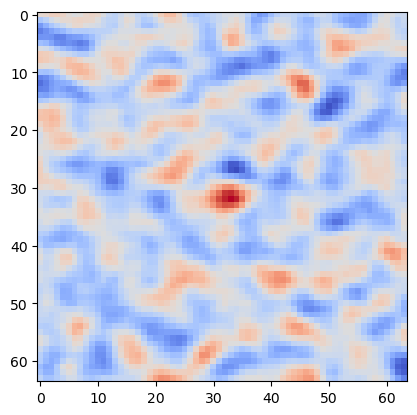

In [6]:
plt.imshow(trimmean, cmap="coolwarm")
print(np.max(trimmean) / np.std(trimmean))
print(np.std(trimmean) * 1e6)

4.0424504


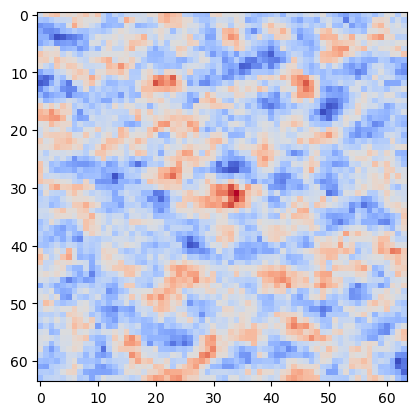

In [7]:
plt.imshow(medim, cmap="coolwarm")
print(np.max(medim)/np.std(medim))

1.0128246610888179
1.0096963129866972
1.0127833091292386
1.0126172954420203
1.0128246621402375


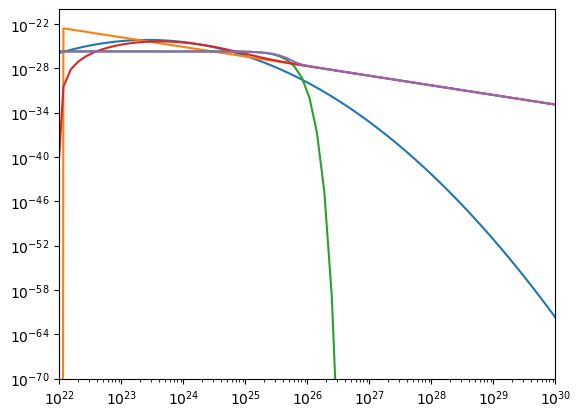

In [83]:
sigma_noise = 2e25
gamma = 1.3
xmax = 1e30
xmin = 1e22
ndex = int(np.log10(xmax) - np.log10(xmin))
sigma_sf = 0.5
mu = 24

def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def power_law(x, gamma, xmin, xmax=xmax):
    if np.size(x) > 1:
        return np.array([power_law(xi, gamma, xmin, xmax) for xi in x])
    else:
        if (x < xmin) or (x > xmax):
            p = 0
        else:
            p = (1-gamma) / (np.power(xmax, 1-gamma) - np.power(xmin, 1-gamma)) * np.power(x, -gamma)
        return p
    
def log_normal(x, mu, sigma):
    if np.size(x) > 1:
        return np.array([log_normal(xi, mu, sigma) for xi in x])
    else:
        if x < 0:
            ln = 0
        else:
            ln = (np.log10(math.e) / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log10(x) - mu) / sigma)**2)
        return ln


def convolution_1(t):
    scale = 1e26
    integrand = lambda x: scale * log_normal(t-x, mu, sigma_sf) * power_law(x, gamma, xmin)
    results = [integrate.quad(integrand, 10**p, 10**(p+0.5))[0] for p in np.arange(np.log10(xmin), np.log10(xmax), 0.5)] 
    return np.sum(results) / scale

def convolution_2(t):
    scale = 1e26
    integrand = lambda x: scale * gaussian(t-x, 0.0, sigma_noise) * convolution_func(x)
    result = integrate.quad(integrand, xmin, xmax, points=10**np.arange(np.log10(xmin), np.log10(xmax), 1))[0] 

    return result / scale

# Define the range of values for x
x = 2.0 * np.sinh(np.log(10) * np.linspace(-np.log10(1e30), np.log10(1e30), 500))
#x = 10**np.linspace(np.log10(xmin), np.log10(xmax), 1000)

ln = log_normal(x, mu, sigma_sf)
pl = power_law(x, gamma, xmin)

c1 = np.array([convolution_1(xi) for xi in x])
c1[np.where(x>1e27)] = pl[np.where(x>1e27)]
convolution_func = interp1d(x, c1, kind='cubic', fill_value=0, bounds_error=False)
c1 = convolution_func(x)
c2 = np.array([convolution_2(xi) for xi in x])
c2[np.where(x>1e27)] = pl[np.where(x>1e27)]
convolution_func = interp1d(x, c2, kind='cubic', fill_value=0, bounds_error=False)
c2 = convolution_func(x)

print(np.sum(0.5 * (ln[:-1] + ln[1:]) * (x[1:] - x[:-1])))
print(np.sum(0.5 * (pl[:-1] + pl[1:]) * (x[1:] - x[:-1])))
print(np.sum(0.5 * (c1[:-1] + c1[1:]) * (x[1:] - x[:-1])))
print(np.sum(0.5 * (c2[:-1] + c2[1:]) * (x[1:] - x[:-1])))

#x = np.linspace(-10**26, 10**26, 1000)
gs = np.array([gaussian(xi, 0.0, sigma_noise) for xi in x])
#c1 = convolution_func(x)
#cn = np.convolve(c1, gs, mode="same") * (x[1] - x[0])

print(np.sum(0.5 * (gs[:-1] + gs[1:]) * (x[1:] - x[:-1])))
#print(np.sum(0.5 * (cn[:-1] + cn[1:]) * (x[1:] - x[:-1])))

plt.plot(x, ln)
plt.plot(x, pl)
plt.plot(x, gs)
plt.plot(x, c1)
plt.plot(x, c2)
plt.xlim([xmin, xmax])
plt.ylim([1e-70, 1e-20])
plt.xscale("log")
plt.yscale("log")

#plt.plot(np.arcsinh(x / 2) / np.log(10), ln)
#plt.plot(np.arcsinh(x / 2) / np.log(10), pl)
#plt.plot(np.arcsinh(x / 2) / np.log(10), gs)
#plt.plot(np.arcsinh(x / 2) / np.log(10), c1)
#plt.plot(np.arcsinh(x / 2) / np.log(10), c2)
#plt.xlim([-26, 26])



1.0127833091292386


(-1e+26, 1e+26)

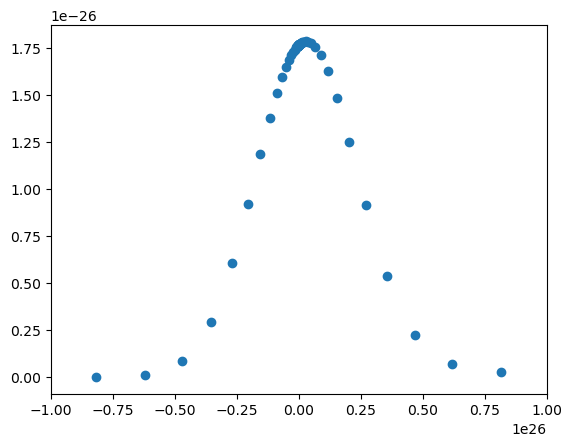

: 

In [87]:
#plt.scatter(x, ln)
#plt.scatter(x, pl)
#plt.scatter(x, gs)
#plt.scatter(x, c1)
plt.scatter(x, c2)
plt.xlim([-1e26, 1e26])
#plt.ylim([1e-40, 1e-22])
#plt.xscale("log")
#plt.yscale("log")

## Plot Histograms

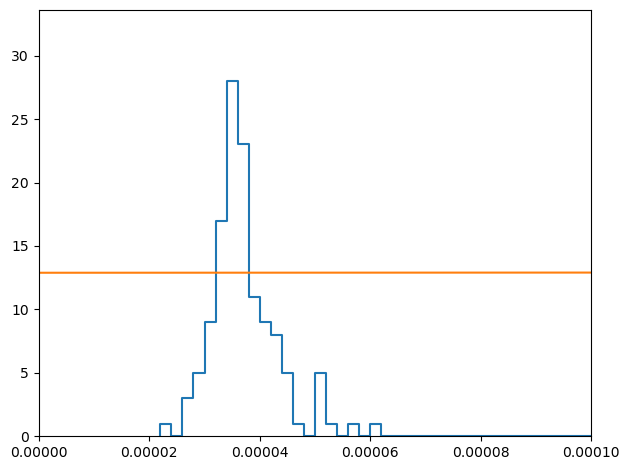

In [33]:
bins = np.arange(2e-5, 1e-4, 2e-6)
hist, binc = np.histogram(mad_list, bins, density=False)
binc = binc[1:]

peaks = np.array(peaks)
idx = np.where(np.abs(peaks) < 0.1)
mu, std = norm.fit(peaks[idx])
x = np.linspace(-1, 1, 10000)
y = norm.pdf(x, mu, std)

plt.step(binc, hist)
plt.plot(x, y)
plt.vlines(mu, 0, 1.2 * np.max(hist), linestyle="--", color="k")
plt.xlim([0, 1e-4])
plt.ylim([0.0, 1.2 * np.max(hist)])
plt.tight_layout()

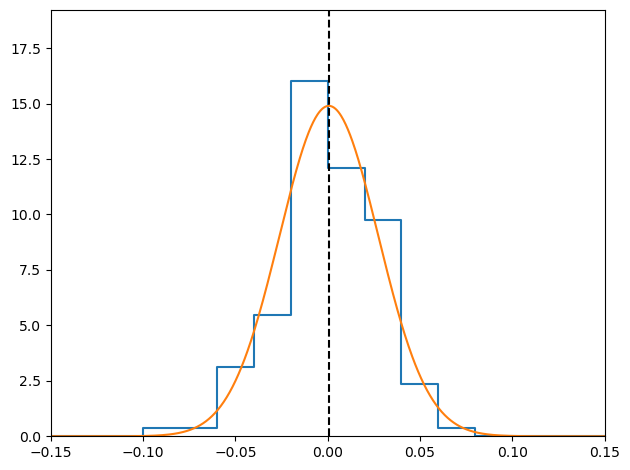

In [10]:
bins = np.arange(-0.2, 0.2, 0.02)
hist, binc = np.histogram(offpoints, bins, density=True)
binc = binc[1:]

offpoints = np.array(offpoints)
idx = np.where(np.abs(offpoints) < 0.1)
mu, std = norm.fit(offpoints[idx])
x = np.linspace(-0.2, 0.2, 1000)
y = norm.pdf(x, mu, std)

plt.step(binc, hist)
plt.plot(x, y)
plt.vlines(mu, 0, 1.2 * np.max(hist), linestyle="--", color="k")
plt.xlim([-0.15, 0.15])
plt.ylim([0.0, 1.2 * np.max(hist)])
plt.tight_layout()
